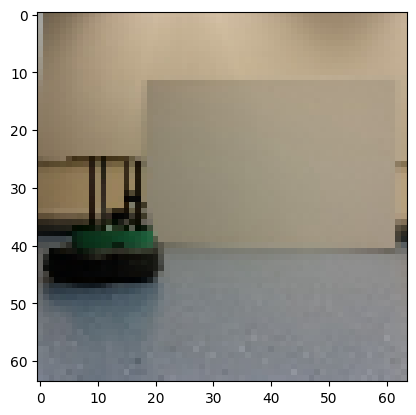

In [47]:

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
# Read in the image
image = cv2.imread('imgs/photos/record-.png')
open_cv_image = np.array(image)
resized_image = cv2.resize(image, (64,64))
colors = np.array(image)/255.0
image=np.array(resized_image)/255.0
imageHSV = np.array(cv2.cvtColor(resized_image, cv2.COLOR_RGB2HSV))/255.0

plt.imshow(image)

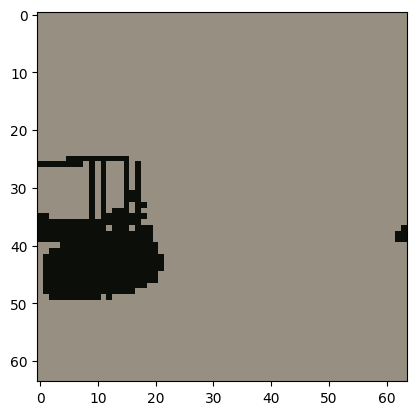

In [3]:
points = image.reshape(-1,3)
# mean shift clustering
from sklearn.cluster import MeanShift, estimate_bandwidth
bandwidth = estimate_bandwidth(points, quantile=0.2, n_samples=500)
#bandwidth = 0
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(points)
labels = ms.labels_
cluster_centers = ms.cluster_centers_

new_seg = np.zeros_like(image)
w = 64
h = 64

for i in range(len(points)):
    new_seg[int(i/w)][int(i%h)] = cluster_centers[labels[i]]
plt.imshow(new_seg)

[0.58939039 0.56299598 0.51034054]


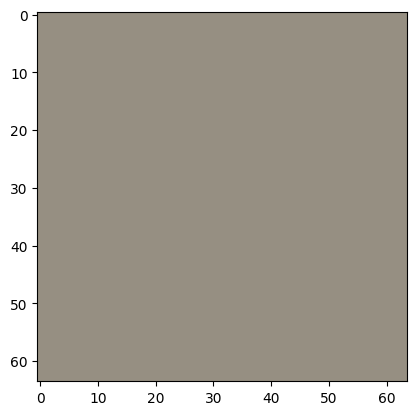

In [4]:
color = new_seg[36][20]
color_img = np.zeros_like(image)

for i in range(len(points)):
    color_img[int(i/w)][int(i%h)] = color

print(color)
plt.imshow(color_img)

In [5]:
prey = [0.20532213, 0.5140056,  0.32135854]
predator = [0.60247678, 0.12115583, 0.09494324] # Red Picked 
wall = [0.8169659 , 0.75140956, 0.62361997] # Be Picked
ground = [0.65224764, 0.67061128, 0.68097509] # bluish gray

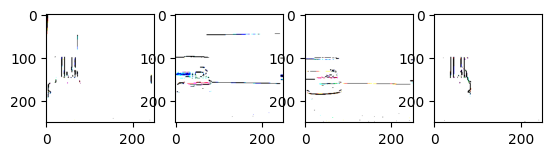

In [6]:

def apply_brightness_contrast(input_img, brightness = 0, contrast = 0):
    
    if brightness != 0:
        if brightness > 0:
            shadow = brightness
            highlight = 255
        else:
            shadow = 0
            highlight = 255 + brightness
        alpha_b = (highlight - shadow)/255
        gamma_b = shadow
        
        buf = cv2.addWeighted(input_img, alpha_b, input_img, 0, gamma_b)
    else:
        buf = input_img.copy()
    
    if contrast != 0:
        f = 131*(contrast + 127)/(127*(131-contrast))
        alpha_c = f
        gamma_c = 127*(1-f)
        
        buf = cv2.addWeighted(buf, alpha_c, buf, 0, gamma_c)

    return buf

thresh = 0.3
contrasted_left = cv2.filter2D(colors,-1,np.array([[+1,0,-1],[+2,0,-2],[+1,0,-1]])) > thresh
contrasted_top = cv2.filter2D(colors,-1,np.array([[+1,+2,+1],[0,0,0],[-1,-2,-1]])) > thresh
contrasted_bottom = cv2.filter2D(colors,-1,np.array([[-1,-2,-1],[0,0,0],[+1,+2,+1]])) > thresh
contrasted_right = cv2.filter2D(colors,-1,np.array([[-1,0,+1],[-2,0,+2],[-1,0,+1]])) > thresh



plt.subplot(1,4,1)
plt.imshow(np.ones_like(colors) - contrasted_left)
plt.subplot(1,4,2)
plt.imshow(np.ones_like(colors) - contrasted_top)
plt.subplot(1,4,3)
plt.imshow(np.ones_like(colors) - contrasted_bottom)
plt.subplot(1,4,4)
plt.imshow(np.ones_like(colors) - contrasted_right)



(250, 250)


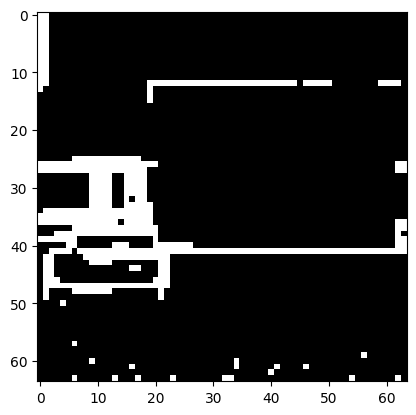

In [7]:
total_edges = contrasted_top + contrasted_bottom + contrasted_left + contrasted_right

total_edges = total_edges.any(axis=2).astype(float)
print(total_edges.shape)
total_edges = np.ones_like(total_edges) * total_edges
total_edges = cv2.dilate(total_edges, np.ones((3,3),np.uint8), iterations=1)
total_edges = cv2.resize(total_edges, (64,64),interpolation=cv2.INTER_NEAREST)
plt.imshow(total_edges,cmap='gray')

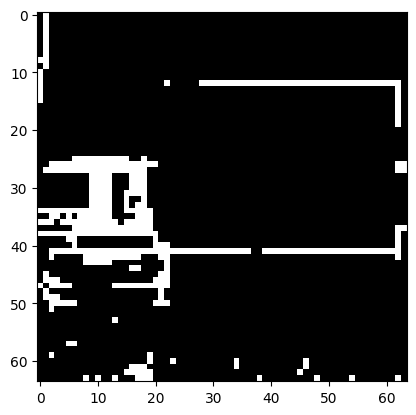

In [8]:
canny = cv2.Canny(open_cv_image, 50, 100)
canny = cv2.dilate(canny, None, iterations=1)
canny = cv2.resize(canny, (64,64), interpolation = cv2.INTER_NEAREST)
plt.imshow(canny,cmap='gray')


[153  30  24]
True
[ 52 131  81]
True
[208 191 159]
False
[166 171 173]
True


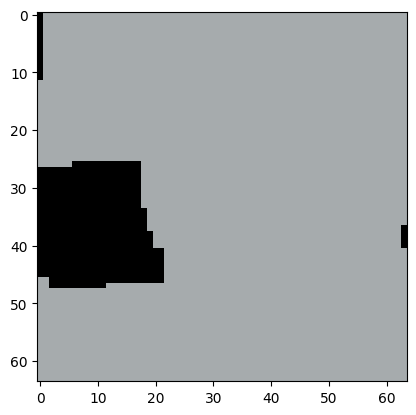

In [9]:
new_image =  resized_image.copy()
for i in range(new_image.shape[0]):
    for j in range(new_image.shape[1]):
        if total_edges[i][j] == 1:
            new_image[i][j] = [0,0,0]
    
features = (np.array([predator,prey,wall,ground]) * 255).astype(np.uint8)
feature_thresholds = [20,20,20,30]
diffs_lo = np.ones_like(features) * np.array([10,10,10,60]).reshape(4,1)
diffs_hi = np.ones_like(features) * np.array([20,20,20,80]).reshape(4,1)


plt.imshow(new_image,cmap='gray')

def equal_any(img,features):
    result = np.zeros_like(img)
    for feature in features:
        print(feature)
        print((img == feature).any())
        result += (img == feature).all(axis=2).astype(np.uint8).reshape(64,64,1) * np.array([255,255,255]).astype(np.uint8)
    
    return result

imageResult = np.zeros_like(new_image)

for i in range(new_image.shape[0]):
    for j in range(new_image.shape[1]):
        for idx in range(len(features)):
            feature = features[idx]
            if np.allclose(new_image[i][j],feature,atol=feature_thresholds[idx]) and (new_image[i][j] != feature).all():
                #print(feature)
                rgb = (int(feature[0]),int(feature[1]),int(feature[2]))
                diff_lo = int(diffs_lo[idx][0])
                diff_hi = int(diffs_hi[idx][0])
                        
                new_image = cv2.floodFill(new_image, None, (j,i),rgb,loDiff=(10,10,10),upDiff=(10,10,10))[1]
                #new_image[mask] = rgb

exclude = equal_any(new_image,features)
#plt.imshow(exclude) 
new_image = new_image * (exclude == 255)
new_image = cv2.dilate(new_image, np.ones((3,3),np.uint8), iterations=1)
plt.imshow(new_image,cmap='gray')

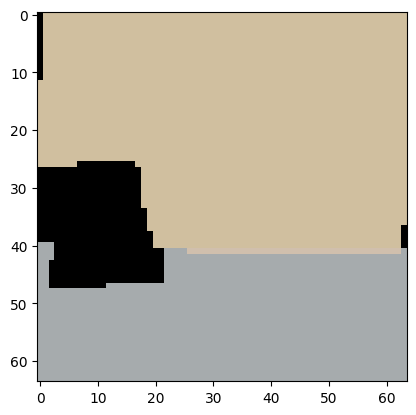

In [58]:
prey = [0.20532213, 0.5140056,  0.32135854]
predator = [0.60247678, 0.12115583, 0.09494324] # Red Picked 
wall = [0.8169659 , 0.75140956, 0.62361997] # Be Picked
ground = [0.65224764, 0.67061128, 0.68097509] # bluish gray

features = (np.array([predator,prey,ground,wall]) * 255).astype(np.uint8)
detection_thresholds = [20,30,20,30]

def compute_edges(_img):
    #plt.imshow(_img)
    thresh = 0.3
    contrasted_left = cv2.filter2D(_img,-1,np.array([[+1,0,-1],[+2,0,-2],[+1,0,-1]])) > thresh
    contrasted_top = cv2.filter2D(_img,-1,np.array([[+1,+2,+1],[0,0,0],[-1,-2,-1]])) > thresh
    contrasted_bottom = cv2.filter2D(_img,-1,np.array([[-1,-2,-1],[0,0,0],[+1,+2,+1]])) > thresh
    contrasted_right = cv2.filter2D(_img,-1,np.array([[-1,0,+1],[-2,0,+2],[-1,0,+1]])) > thresh

    
    total_edges = contrasted_top + contrasted_bottom + contrasted_left + contrasted_right
    #print(total_edges.shape)
    total_edges = total_edges.any(axis=2).astype(float)
    total_edges = np.ones_like(total_edges) * total_edges
    
    total_edges = cv2.dilate(total_edges, np.ones((3,3),np.uint8), iterations=1)
    total_edges = cv2.resize(total_edges, (64,64),interpolation=cv2.INTER_NEAREST)

    
    return total_edges

def flood_fill(_img,features,thresholds):
    img = _img.copy()
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            for idx in range(len(features)):
                feature = features[idx]
                if (np.allclose(img[i][j],feature,atol=thresholds[idx]) and (img[i][j] != feature).all()) :
                    #print(feature)
                    rgb = (int(feature[0]),int(feature[1]),int(feature[2]))
                    img = cv2.floodFill(img, None, (j,i),rgb,loDiff=(10,10,10),upDiff=(10,10,10))[1]
    return img 

def generate_mask(img,features):
    result = np.zeros((64,64,1))
    for feature in features:
        result += (img == feature).all(axis=2).astype(np.uint8).reshape(64,64,1)

    
    return result

def segment(_img):

    img = np.array(_img).copy()

    edges = compute_edges(img/255.0)
    #plt.imshow(all_edges,cmap='gray')
    img = np.array(cv2.resize(img, (64,64),interpolation=cv2.INTER_NEAREST))

    # Add the edges to the image
    img = img * (edges == 0).reshape(64,64,1)
    
    filled = flood_fill(img,features ,detection_thresholds)
    
    mask = generate_mask(filled,features)
    #plt.imshow(mask,cmap='gray')
    #plt.imshow(mask)
    img = filled * (mask == 1)
    img = cv2.dilate(img, np.ones((3,3),np.uint8), iterations=1)
    
    return edges,filled,mask,img
    
#_,_,_,segmented = segment(open_cv_image)

plt.imshow(segment(open_cv_image)[-1])

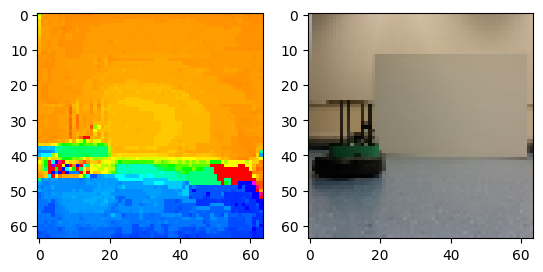

In [11]:

def all_close(x):
    return np.allclose(x,features[1],atol=40)

import colorsys
def to_HSV(rgb):
    #print(rgb.shape)
    hsv = np.array(colorsys.rgb_to_hsv(rgb[0],rgb[1],rgb[2]))
    #hsv[0] = hsv[0] * 255
    #hsv[1] = hsv[1] * 255
    return hsv

def to_RGB(hsv):
    #print(hsv)
    rgb = np.array(colorsys.hsv_to_rgb(hsv[0],hsv[1],hsv[2]))
    #print(rgb)
    return rgb


def all_closest(x,features,thresholds):
    best_idx = 0
    best_val = np.sum(np.abs(x - features[0])**2)

    for i in range(1,len(features)):
        feature = features[i]
    
        diff = np.abs(x - feature)
        dist = np.sum(diff**2)

        if dist < best_val:
            best_val = dist
            best_idx = i

    return best_idx if (best_val < thresholds[best_idx]) else -1

        

vectorized_allclose = np.vectorize(lambda x: all_closest(x,features,[100,100,100,100]),signature='(n)->()')

to_HSV_vec = np.vectorize(to_HSV,signature='(n)->(n)')
to_RGB_vec = np.vectorize(to_RGB,signature='(n)->(n)')

hsv_features = to_HSV_vec(features)

close_nes_img = to_HSV_vec(resized_image).reshape(64,64,3)
close_nes_img = vectorized_allclose(close_nes_img).reshape(64,64,1)
#print(close_nes_img.max())
#print(close_nes_img.min())
r = np.zeros_like(resized_image).astype(np.float32)
for i in range(64):
    for j in range(64):
        r[i][j] = features[close_nes_img[i][j]] if close_nes_img[i][j] != -1 else [0,0,0]
r = to_HSV_vec(resized_image).reshape(64,64,3)
plt.subplot(1,2,1)
#r = cv2.cvtColor(r.astype(np.float32),cv2.COLOR_HSV2RGB)

r[:,:,1] = 1
r[:,:,2] = 255
r = to_RGB_vec(r.reshape(64*64,3)).reshape(64,64,3)
plt.imshow(r.astype(np.uint8),cmap='gray')
plt.subplot(1,2,2)

plt.imshow(resized_image,cmap='gray')

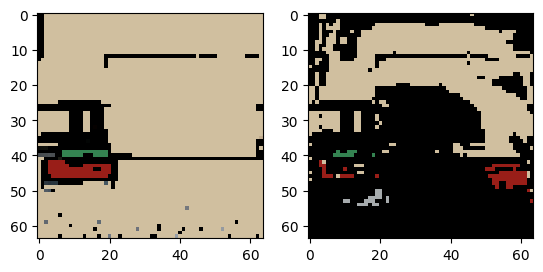

In [12]:
hsv_features = to_HSV_vec(features)

hsv = to_HSV_vec(resized_image).reshape(64,64,3)

#best_features = np.ones((64,64,1)) * -1

def best_feature_fn(x):
    # x is black
    if x[2] == 0:
        #print(x)
        return np.array([-1,np.Inf])
    
    dist = np.Inf
    best_idx = -1
    for i in range(len(hsv_features)):
        feature = hsv_features[i]
        

        d = np.abs(x[0] - feature[0])
        if d < dist:
            dist = d
            best_idx = i

    return np.array([best_idx, dist])

best_feature = np.vectorize(best_feature_fn,signature='(n)->(m)')

#best_features = best_feature(hsv).reshape(64,64,2)
#mask = (best_features[:,:,1] < .019).reshape(64,64,1)
#print(re.shape)
#re = (features[best_features.astype(np.int32)[:,:,0]] * mask).reshape(64,64,3)

def flood_fill2(_img,features,exclude):
    img = _img.copy()
    
    hsv = to_HSV_vec(img).reshape(64,64,3)
    
    best_features = best_feature(hsv).reshape(64,64,2)
    mask = (best_features[:,:,1] < .01).reshape(64,64,1)
    best_features = features[best_features.astype(np.int32)[:,:,0]] * mask
    plt.imshow(best_features)
    #plt.imshow(best_features.astype(np.uint8))
    #print(best_features.shape)
    #exclude = np.zeros((64+2,64+2)).astype(np.uint8)
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            feature = best_features[i][j]
            # feature != [0,0,0]

            if  feature.any() and (feature != img[i][j]).any():
                #print(i,j)
                rgb = (int(feature[0]),int(feature[1]),int(feature[2]))
                num,img,exclude,rect = cv2.floodFill(img, exclude, (j,i),rgb,loDiff=(10,10,10),upDiff=(10,10,10))
                #plt.imshow(exclude)
                #return img
    return img 

#plt.imshow()
img = np.array(open_cv_image).copy()

edges = compute_edges(img/255.0)
#plt.imshow(all_edges,cmap='gray')
img = np.array(cv2.resize(img, (64,64),interpolation=cv2.INTER_NEAREST))


    # Add the edges to the image
img = img * (edges == 0).reshape(64,64,1)
exclude = np.zeros((64+2,64+2)).astype(np.uint8)
for i in range(exclude.shape[0]):
    for j in range(exclude.shape[1]):
        if i >= 65 or i <= 0 or j >= 65 or j <= 0:
            exclude[i][j] = 1
        else:
            exclude[i][j] = edges[i-1][j-1]
 
plt.subplot(1,2,2)
plt.imshow(exclude,cmap='gray')
img = flood_fill2(img,features,exclude)
#other = 
#img = cv2.floodFill(img, None, (40,50),(255,255,255),loDiff=(10,10,10),upDiff=(10,10,10))[1]

plt.subplot(1,2,1)
plt.imshow(img)
plt.show()

(4, 3)
[[1.0943913e-02 3.3064208e-03 6.0000002e-01]
 [5.5696201e-01 2.3649156e-03 5.1372552e-01]
 [7.7310920e-01 1.5867618e-04 6.7843139e-01]
 [1.5366146e-01 9.2383107e-04 8.1568629e-01]]


AttributeError: 'Axes3DSubplot' object has no attribute 'rotate'

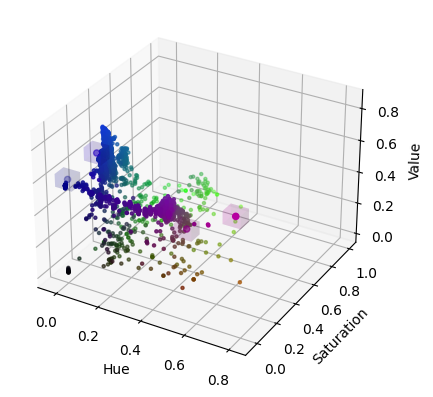

In [54]:
# 3d color plot 
ax = plt.figure().add_subplot(projection='3d')
points = imageHSV.reshape((-1,3)) 

colors = image.reshape((-1,3))
#points = np.apply_along_axis(lambda x: [x[0], x[1], x[2]], 1,points)
print(features.shape)
features_hsv = cv2.cvtColor(features.reshape(4,1,3).astype(np.float32),cv2.COLOR_RGB2HSV).reshape(4,3) / 255.0
print(features_hsv)

current_threshold_int = 10
current_threshold = current_threshold_int / 255.0
#half_ct = current_threshold / 2

ax.scatter(features_hsv[:,0], features_hsv[:,1], features_hsv[:,2], c=features_hsv, marker='o')

ax.bar3d(features_hsv[:,0] -current_threshold, features_hsv[:,1] -current_threshold, features_hsv[:,2] -current_threshold,current_threshold * 2 ,current_threshold * 2 ,current_threshold * 2, color=features_hsv, alpha=0.1)
ax.scatter(points[:,0], points[:,1], points[:,2], c=points, marker='.')
ax.set_xlabel('Hue')
ax.set_ylabel('Saturation')
ax.set_zlabel('Value')
# show from other site
ax

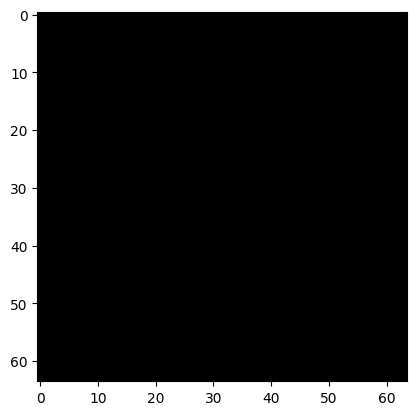

In [41]:
newImg = image.copy()

feature = features_hsv[0]
inrange = cv2.inRange(imageHSV,feature-current_threshold_int,feature+current_threshold_int)
plt.imshow(inrange,cmap='gray')
   

11


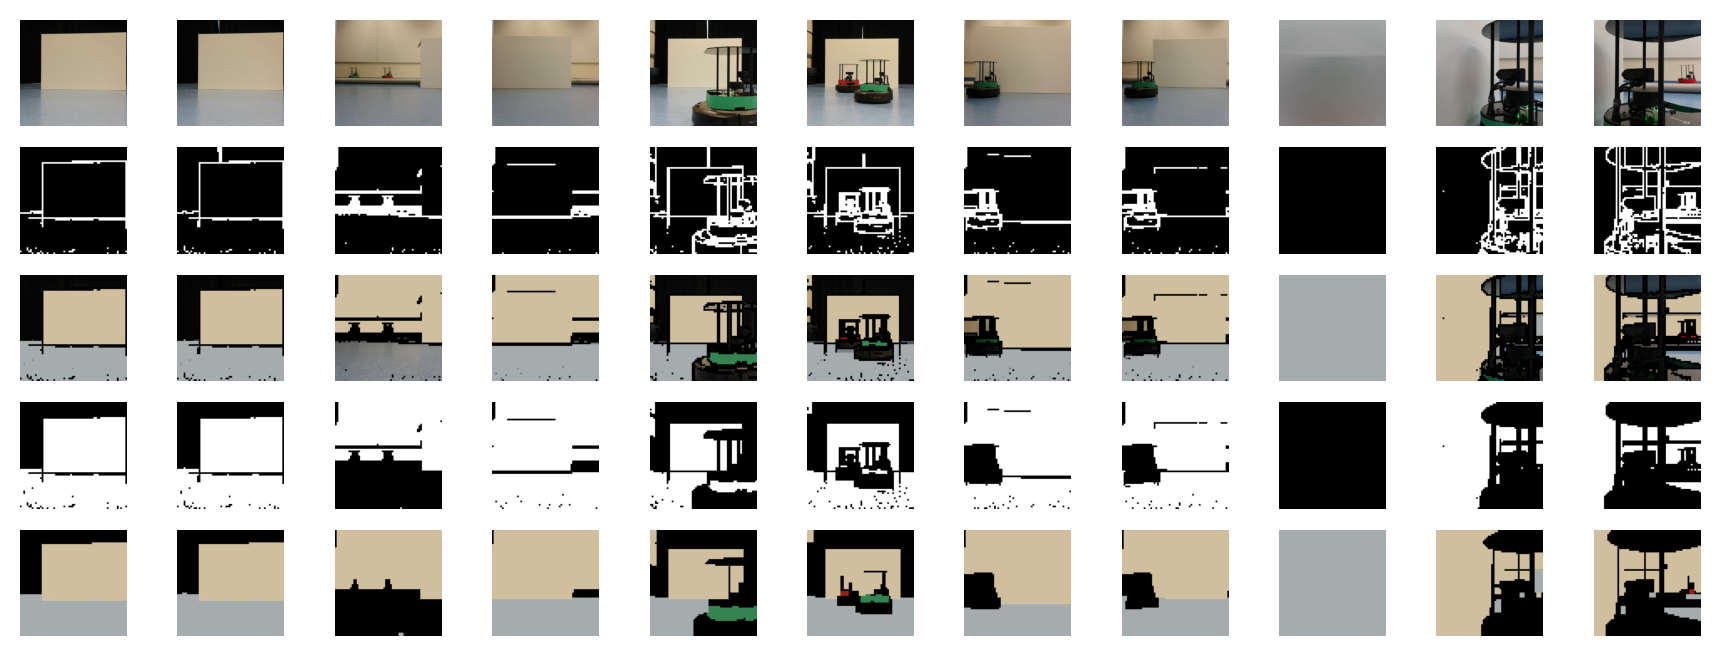

In [ ]:
from glob import glob

def get_images(path):
    images = []
    for filename in glob(path):
        img = cv2.imread(filename)
        if img is not None:
            images.append(img)
    return images

imgs = get_images('imgs/photos/*.png')
print(len(imgs))

plt.figure(figsize=(len(imgs),4),dpi=200)
for i in range(len(imgs)):
    plt.subplot(5,len(imgs),i + 1)
    plt.imshow(imgs[i])
    plt.axis('off')
    results = list(segment(imgs[i]))
    
    for j in range(len(results)):
        plt.subplot(5,len(imgs),i + 1 + len(imgs) * (j+1))
        plt.imshow(results[j],cmap='gray')
        plt.axis('off')
    
    

In [59]:
segment(open_cv_image)

(array([[1., 1., 0., ..., 0., 0., 0.],
        [1., 1., 0., ..., 0., 0., 0.],
        [1., 1., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 1., 0.]]),
 array([[[  0,   0,   0],
         [  0,   0,   0],
         [208, 191, 159],
         ...,
         [208, 191, 159],
         [208, 191, 159],
         [208, 191, 159]],
 
        [[  0,   0,   0],
         [  0,   0,   0],
         [208, 191, 159],
         ...,
         [208, 191, 159],
         [208, 191, 159],
         [208, 191, 159]],
 
        [[  0,   0,   0],
         [  0,   0,   0],
         [208, 191, 159],
         ...,
         [208, 191, 159],
         [208, 191, 159],
         [208, 191, 159]],
 
        ...,
 
        [[166, 171, 173],
         [166, 171, 173],
         [166, 171, 173],
         ...,
         [166, 171, 173],
         [166, 171, 173],
         [166, 171, 173]],
 
        [[166, 171, 173],
         [166, 171